Fiber Bragg Grating Modeling
Erdogan97 - Fiber Grating Spectra

In [ ]:
from typing import Union, Literal, Callable
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from typing import Union, Literal, Callable
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

class FiberBraggGrating:
    def __init__(self,
                 n_eff : float = 1.45,
                 dn_eff: float = 1e-3,
                 v: float = 1,
                 l_bragg: float = 1550.0e-9,
                 length: float = 1e-3,
                 apodization: Union[
            Literal["uniform", "raised_sine", "gaussian", "hamming"], Callable
        ] = "uniform",):
        self.n_eff = n_eff
        self.dn_eff = dn_eff
        self.v = v
        self.l_bragg = l_bragg
        self.length = length
        self.apodization = apodization
        self.Lambda = self.l_bragg/(2*self.n_eff)
        self.reflectivity = None
        self.wl = None
        self.phase = None
        self.tau = None
        self.l_start = None
        self.l_end = None
        self.samples = None
        self.segments = 100
        self.fwhm_bw = None
        self.fwtm_bw = None
        self.dispersion = None
        self.n_eff_z = None
        self.refl_peak = None
        self.strain = None
        self.epsilon = []
        self.zz = []
        self.s1 = None
        self.s2 = None
        self.s1_v = None
        self.s2_v = None
        self.features = None


    def dn_eff_z (self,z):
        if self.apodization == 'gaussian':
            rho = 10
            return self.dn_eff*np.exp(-rho*((z-self.length/2)/(self.length))**2)
        elif self.apodization == 'raised_sine':
            return self.dn_eff*(np.sin(np.pi*z/self.length))**2
        elif self.apodization == 'hamming':
            return self.dn_eff*(0.54+0.46*np.cos(np.pi*(z-self.length/2)/self.length))
        else:
            self.apodization = "uniform"
            return self.dn_eff

    def sigma(self,z,l):
        h = 2*np.pi/l
        return h*(self.dn_eff_z(z))

    def delta(self,l):
        return 2*np.pi*self.n_eff*((1/l) - (1/self.l_bragg))

    def kappa(self,z,l):
        h = self.v*np.pi/l
        return h*self.dn_eff_z(z)

    def strain_sigma(self,z):
        pe = 0.26
        s = self.strain * (z-self.length/2) * 1e3 #linear strain
        s_dot = self.strain*1e3 #gradient is constant
        L_n = self.Lambda * (1 + (1-pe)*s+(1-pe)*z*s_dot) #eq15 (P04)
        self.epsilon.append(s)
        self.zz.append(z)
        return L_n


    def sigma_hat(self,z,l):
        if self.strain == None or self.strain==0:
          return self.delta(l) + self.sigma(z,l)
        else:
          return 2*np.pi*self.n_eff/l+ self.sigma(z,l) - np.pi/(self.strain_sigma(z)) #eq16 (P04)

    def gamma(self,z,l):
        kg = self.kappa(z,l)
        ks = self.sigma_hat(z,l)
        if kg**2>=ks**2:
            return np.sqrt(kg**2 - ks**2)
        else:
            return 1j*np.sqrt(abs(kg**2 - ks**2))

    def transfer_matrix(self,dz, g, s_hat,l,kp):
        cosh_term = np.cosh(g*dz)
        sinh_term = np.sinh(g*dz)
        return np.array([[cosh_term+1j*s_hat*sinh_term/g,-1j*kp*sinh_term/g],
                         [1j*kp*sinh_term/g, cosh_term-1j*s_hat*sinh_term/g]])

    def get_transfer_matrix(self,dz,l):
        T_t = []
        # Loop through grating segments
        for z in np.arange(dz, self.length + dz, dz):
            # Calculate parameters at current position
            gamma_z = self.gamma(z-dz/2,l)
            sigma_hat_z = self.sigma_hat(z-dz/2,l)
            k = self.kappa(z-dz/2,l)
        # Get transfer matrix for this segment
            T_z = self.transfer_matrix(dz, gamma_z, sigma_hat_z,l,k)
            if z==dz:
                T_t = T_z
            else:
                T_t = np.matmul(T_t,T_z)
        return T_t


    def simulate(self,segments: int =100,l_start:float=1545e-9,l_end:float = 1555e-9,samples:int = 1000):
        self.wl = np.linspace(l_start, l_end, samples)
        self.reflectivity = []
        self.phase = []
        self.l_start = l_start
        self.l_end = l_end
        self.samples = samples
        self.segments = segments
        dz = self.length/self.segments
        for wl in self.wl:
            T = self.get_transfer_matrix(dz,wl)
            refl = (abs(-T[1][0]/T[1][1]))**2
            phase = np.angle((-T[1][0]/T[1][1]))
            self.reflectivity.append(refl)
            self.phase.append(phase)
        i_max = np.argmax(self.reflectivity)
        self.peak_refl = self.wl[i_max]

    def plot_reflectivity(self):
        if self.reflectivity == None:
            print("First run the simulation method")
        else:
           plt.plot(self.wl, self.reflectivity)
           title = (
               f"$\lambda_{{bragg}}={self.l_bragg * 1e6:.2f}$ μm, L={self.length * 1e3:.1f} mm, $n_{{eff}}= {self.n_eff} $ "
               f"$\delta n_{{eff}}={self.dn_eff:.6f}$, apodization = {self.apodization}\nFBG Reflection Spectrum")
           plt.suptitle(title)
           plt.xlabel('Wavelength (nm)')
           plt.ylabel('Reflectivity')
           plt.show()

    def calc_group_delay(self):
        self.tau = []
        ind = []
        self.tau.append(self.phase[0])
        for i in range(1, len(self.wl)):
            delta_lambda = (self.l_end - self.l_start)/self.samples
            ph = self.phase[i - 1] - self.phase[i]
            if (np.abs(ph) > 0.2):  # Derivative at the phase discontinuities / handle later
                ind.append(i)
                ph = self.tau[i-1]
                self.tau.append(ph)
            else:
                self.tau.append(((self.wl[i]) ** 2 / (2 * np.pi * 3e-4) * (ph) / delta_lambda)) #picoseconds
        self.tau[0] = self.tau[1]
        for i in range(0, len(ind)-1):
            self.tau[ind[i]] = 0.5*(self.tau[ind[i]-1]+self.tau[ind[i]+1]) #value = avg of previous and next value
            #print(ind[i])
    def plot_tau(self):
        if self.tau == None:
            print("First run the simulation method and calc_group_delay method")
        else:
           plt.plot(self.wl, self.tau)
           title = (
               f"$\lambda_{{bragg}}={self.l_bragg * 1e6:.2f}$ μm, L={self.length * 1e3:.1f} mm, $n_{{eff}}= {self.n_eff} $ "
               f"$\delta n_{{eff}}={self.dn_eff:.6f}$, apodization = {self.apodization}\nFBG Group Delay")
           plt.suptitle(title)
           plt.xlabel('Wavelength (nm)')
           plt.ylabel('Group Delay (ps)')
           plt.show()

    def calc_dispersion(self):#ps/nm
        dtau_p = None
        self.dispersion = []
        delta_lambda = (self.l_end - self.l_start)/self.samples
        for i in range(1, len(self.tau)-1):
            dtau = (self.tau[i+1]-self.tau[i])
            self.dispersion.append(dtau/delta_lambda)
        self.dispersion.insert(0, self.dispersion[0])  # oth element = 1th element
        self.dispersion.append(self.dispersion[-1]) #last element = next to last element


    def calc_bw(self):
   #calculate FWHM BandWidth
        m = len(self.reflectivity)
        r_max = np.max(self.reflectivity)
        i_max = np.argmax(self.reflectivity)
        thres = r_max / 2
        i_high = -5
        i_low = -5
        for i in range(i_max,m):
            if round(self.reflectivity[i],1) < thres:
                i_high = i-1
                break
        for i in range(0,i_max):
            if round(self.reflectivity[i],1) >= thres:
                i_low = i
                break
        self.fwhm_bw = self.wl[i_high]-self.wl[i_low]
        print("FWHM BW is " + str(self.fwhm_bw*1e9) + " nm")
        i_high = -5
        i_low = -5
        thres = r_max / 10
        for i in range(i_max,m):
            if round(self.reflectivity[i],1) < thres:
                i_high = i-1
                break
        for i in range(0,i_max):
            if round(self.reflectivity[i],1) >= thres:
                i_low = i
                break
        self.fwtm_bw = self.wl[i_high]-self.wl[i_low]
        print("FWTM BW is " + str(self.fwtm_bw*1e9) + " nm")

    def get_n_eff_z(self):
        self.n_eff_z = []
        dz = self.length/self.segments
        dz_z = []
    #n_eff across the fiber
        for z in np.arange(dz, self.length + dz, dz):
            s=self.dn_eff_z(z)
            s = self.n_eff + s*np.cos(np.pi*2*z/self.Lambda)
            self.n_eff_z.append(s)
            dz_z.append(z)
        plt.plot(dz_z,self.n_eff_z)
        plt.suptitle("Effective index")
        plt.xlabel('Position in the fiber (m)')
        plt.ylabel('Effective Index')
        plt.show()

    def plot_dispersion(self):
        if self.tau == None:
            print("First run the simulation method and calc_group_delay method and calc_dispersion method")
        else:
           plt.plot(self.wl, self.dispersion)
           title = (
               f"$\lambda_{{bragg}}={self.l_bragg * 1e6:.4f}$ μm, L={self.length * 1e3:.1f} mm, $n_{{eff}}= {self.n_eff} $ "
               f"$\delta n_{{eff}}={self.dn_eff:.6f}$, apodization = {self.apodization}\nFBG Dispersion")
           plt.suptitle(title)
           plt.xlabel('Wavelength (nm)')
           plt.ylabel('Dispersion (ps/nm)')
           plt.show()



    def find_sidelobes (self):
      x = x = np.array(self.reflectivity)
      peaks, properties = find_peaks(x,  width=6)
      index = np.argmax(properties['prominences'])
      plateau_threshold = 0.02  # Adjust this value as needed
      i = np.max(x)
      j = np.argmax(x)
      prom = properties['prominences'][np.logical_or(x[peaks] < i * (1 - plateau_threshold), peaks == j)]
      peaks = peaks[np.logical_or(x[peaks] < i * (1 - plateau_threshold), peaks == j)]
      index = np.argmax(prom)
      s1 = index - 1
      s2 = index + 1
      try:
        self.s1_v = prom[s1]
        self.s1 = self.wl[peaks[index - 1]]
      except:
        self.s1_v = 0
        self.s1 = None

      try:
        self.s2_v = prom[s2]
        self.s2 = self.wl[peaks[index + 1]]
      except:
        self.s2_v = 0
        self.s2 = None
      print ("Max is at " + str(self.wl[peaks[index]]) + " nm")


    def extract_features(self):
      #[max_wl, max_refl, sl1_p, sl2_p, bw, bw_z]
      self.features = []
      self.features.append(self.peak_refl)
      if self.s1_v is None:
        self.find_sidelobes()
      m = np.max(self.reflectivity)
      self.features.append(m)
      self.features.append(10*np.log10(self.s1_v/1))
      self.features.append(10*np.log10(self.s2_v/1))
      if self.fwhm_bw is None:
        self.calc_bw()
      self.features.append(self.fwhm_bw)
      self.features.append(self.fwtm_bw)



Grating period Λ is 533.2191780821918 nm


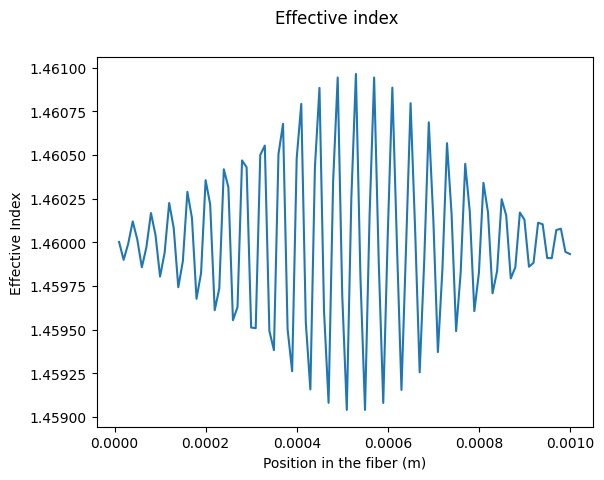

In [ ]:
fbg = FiberBraggGrating(length = 1e-3, dn_eff =1e-3, apodization = 'gaussian', n_eff = 1.46, l_bragg = 1557e-9)
print("Grating period Λ is "+ str(fbg.Lambda*1e9)+ " nm")
fbg.get_n_eff_z()

In [ ]:
fbg.simulate(l_start = 1550.0*1e-9,l_end = 1565*1e-9,samples=1000,segments = 200)
print("The peak reflectivity is for "+ str(fbg.peak_refl*1e9)+" nm, and the offset from the bragg wavelength is " + str((fbg.peak_refl-fbg.l_bragg)*1e9) + " nm")

The peak reflectivity is for 1557.7927927927929 nm, and the offset from the bragg wavelength is 0.7927927927927284 nm


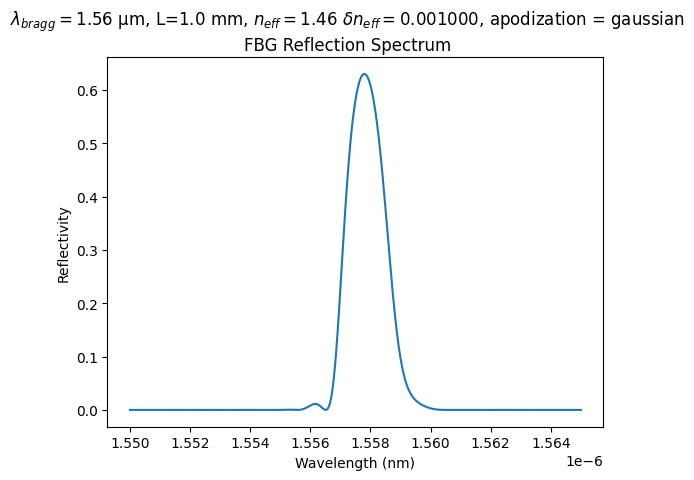

In [ ]:
fbg.plot_reflectivity()

In [ ]:
fbg.extract_features()
fbg.features

Max is at 1.5577927927927928e-06 nm
FWHM BW is 1.3963963963963335 nm
FWTM BW is 2.4024024024024833 nm


[1.5577927927927928e-06,
 0.6302873913210604,
 -19.493445887728026,
 -50.95018825081917,
 1.3963963963963334e-09,
 2.402402402402483e-09]

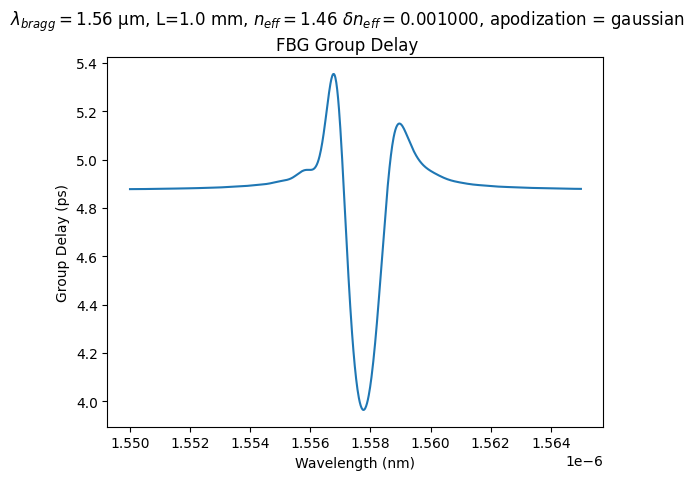

In [ ]:
fbg.calc_group_delay()
fbg.plot_tau()

FWHM BW is 1.3963963963963335 nm
FWTM BW is 2.4024024024024833 nm


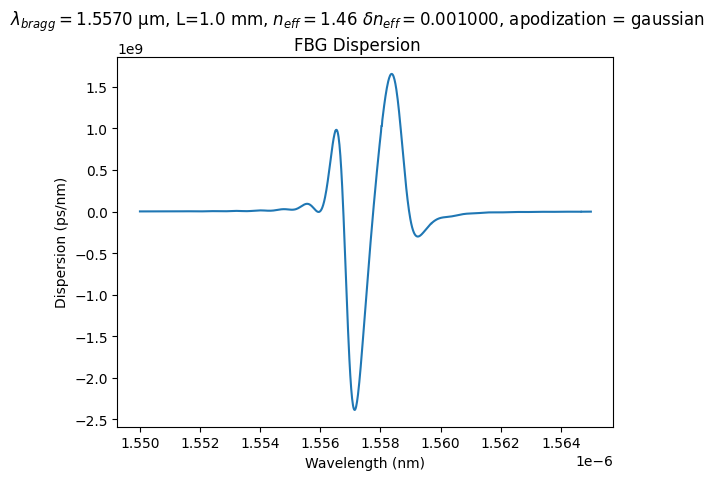

In [ ]:
fbg.calc_bw()
fbg.calc_dispersion()
fbg.plot_dispersion()


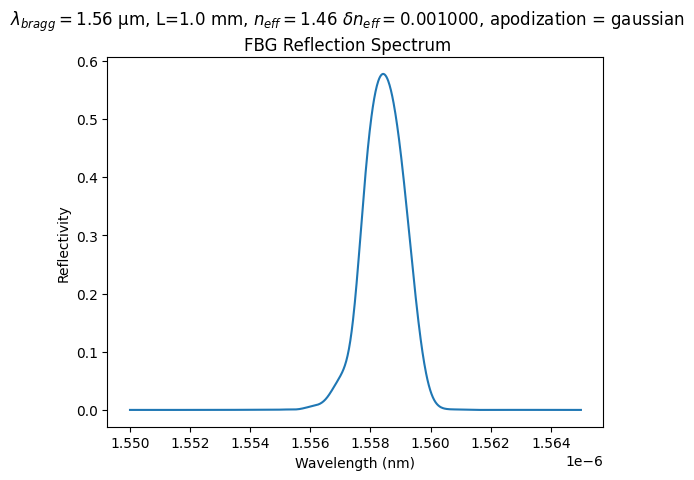

In [ ]:
fbg.zz = []
fbg.epsilon = []
fbg.strain = 1000e-6
fbg.simulate(l_start = 1550.0*1e-9,l_end = 1565*1e-9,samples=1000,segments = 200)
fbg.plot_reflectivity()

In [ ]:
fbg.extract_features()
fbg.features

[1.5584234234234234e-06,
 0.5772441219681005,
 -19.493445887728026,
 -50.95018825081917,
 1.3963963963963334e-09,
 2.402402402402483e-09]

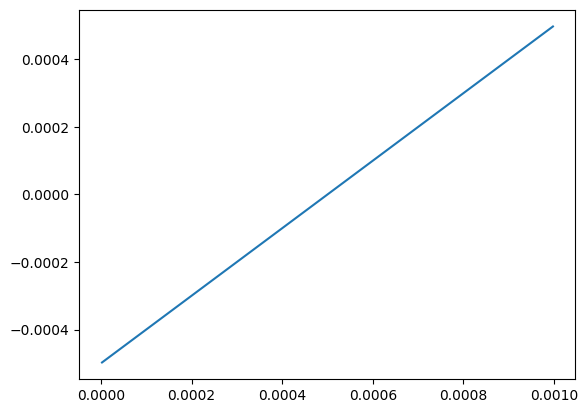

In [ ]:
plt.plot(fbg.zz,fbg.epsilon)


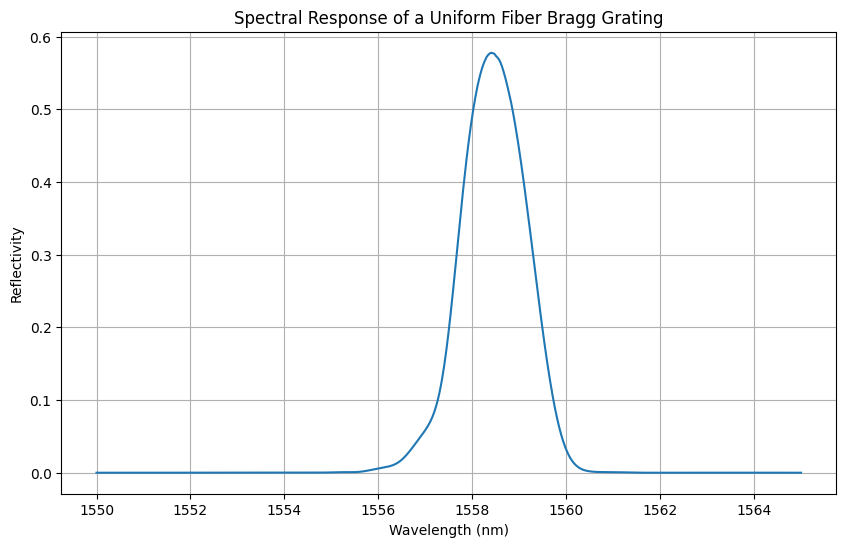

In [ ]:
#RK45 numerical solution
import matplotlib.pyplot as plt
import numpy as np
f = fbg.apodization
l_bragg = fbg.l_bragg
n_eff = fbg.n_eff
dn_eff = fbg.dn_eff
v=1
strain = 1000e-6
Lambda = fbg.Lambda
length = fbg.length

def dn_eff_z (z,f):
    if f == 'gaussian':
        rho = 10
        return dn_eff*np.exp(-rho*((z-length/2)/(length))**2)
    elif f == 'raised_sine':
        return dn_eff*(np.sin(np.pi*z/length))**2
    elif f == 'hamming':
        return dn_eff*(0.54+0.46*np.cos(np.pi*(z-length/2)/length))
    else:
        return dn_eff

def sigma(z,f,l):
    h = 2*np.pi/l
    return h*(dn_eff_z(z,f))

def delta(l):
    return 2*np.pi*n_eff*((1/l) - (1/l_bragg))

def kappa(z,l,f):
    h = v*np.pi/l
    return h*dn_eff_z(z,f)

def strain_sigma(z):
        pe = 0.26
        s = strain * (z-length/2) * 1e3
        s_dot = strain*1e3
        L_n = Lambda * (1 + (1-pe)*s+(1-pe)*z*s_dot)
        return L_n


def sigma_hat(z,f,l):
  if strain == None or strain==0:
    return delta(l) + sigma(z,f,l)
  else:
    return 2*np.pi*n_eff/l + sigma(z,f,l) - np.pi/(strain_sigma(z))

from scipy.integrate import solve_ivp

def coupled_mode_equations(z, y, d,lambda_,f):
    k = kappa(z,lambda_,f)
    s = sigma_hat(z,f,lambda_)
    A = y
    dAdz = -1j*kappa(z,lambda_,f) - 2j*sigma_hat(z,f,lambda_)*A - 1j*kappa(z,lambda_,f)*A**2
    return [dAdz]

# Wavelength range around the Bragg wavelength to analyze
wavelengths = np.linspace(1557e-9 - 7e-9, 1557e-9 + 8e-9, 1000)
reflectivities = []

# Solve the equations for each wavelength
for lambda_ in wavelengths:


    A0 = 0+0j # Initial amplitude of the forward wave


    d = delta(lambda_)
    # Solve the differential equations
    zs = np.linspace(0, length, 1000)


    solution = solve_ivp(coupled_mode_equations, [length, 0], [A0], t_eval=zs[::-1], args=(d,lambda_,f))

    # Compute reflectivity at the end of the grating
    A_end = solution.y[0, -1]

    reflectivity = np.abs(A_end)**2
    reflectivities.append(reflectivity)
# Plot the spectral response
plt.figure(figsize=(10, 6))
plt.plot(wavelengths * 1e9, reflectivities, label='Reflectivity')
plt.title('Spectral Response of a Uniform Fiber Bragg Grating')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectivity')
plt.grid(True)

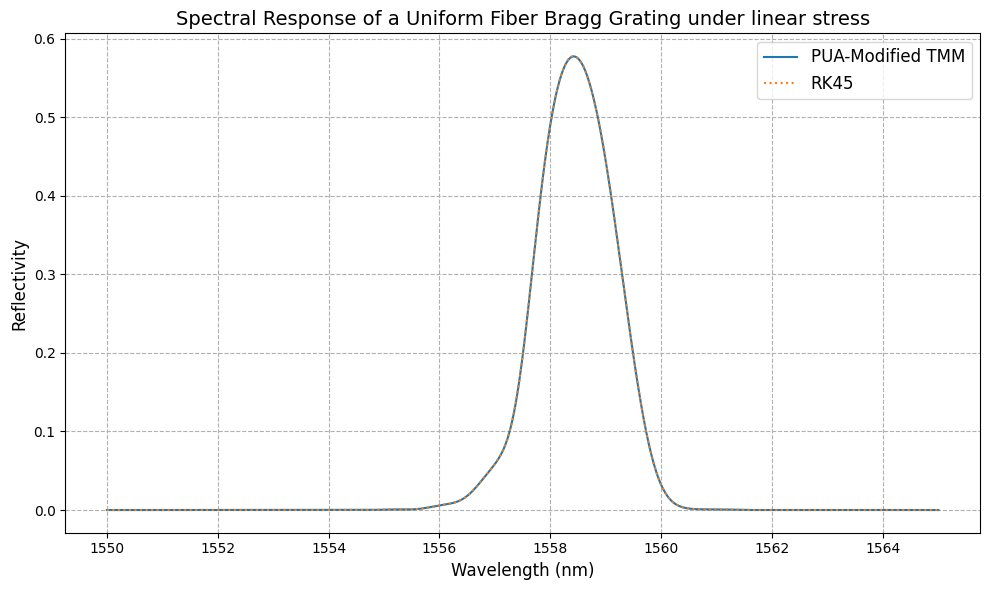

In [ ]:
plt.figure(figsize=(10, 6))  #
plt.plot(wavelengths * 1e9, fbg.reflectivity, label='PUA-Modified TMM', linestyle='-')  # Solid line for the first reflectivity
plt.plot(wavelengths * 1e9, reflectivities, label='RK45', linestyle=':')  # Dashed line for the second reflectivity

plt.title('Spectral Response of a Uniform Fiber Bragg Grating under linear stress', fontsize=14)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectivity', fontsize=12)
plt.grid(True, linestyle='--')  # Dashed gridlines for better visual separation
plt.legend(fontsize=12)       # Add a legend to distinguish the two reflectivity curves

plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

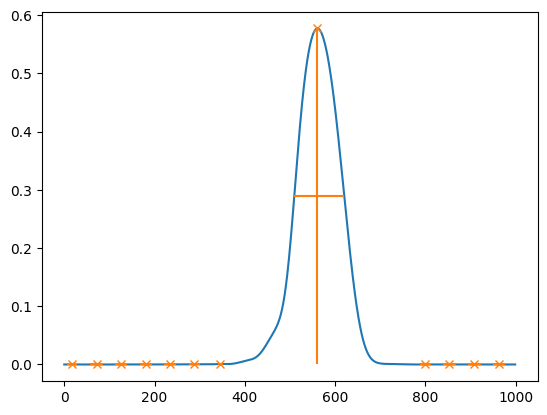

561


In [ ]:
x = np.array(fbg.reflectivity)

peaks, properties = find_peaks(x,  width=6)



plateau_threshold = 0.02  # Adjust this value as needed
i = np.max(x)
j = np.argmax(x)
prom = properties['prominences'][np.logical_or(x[peaks] < i * (1 - plateau_threshold), peaks == j)]
peaks = peaks[np.logical_or(x[peaks] < i * (1 - plateau_threshold), peaks == j)]
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=x[peaks] - prom,
           ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()
print(np.argmax(x))

In [ ]:
ref = -10*np.log10(1/np.array(fbg.reflectivity))

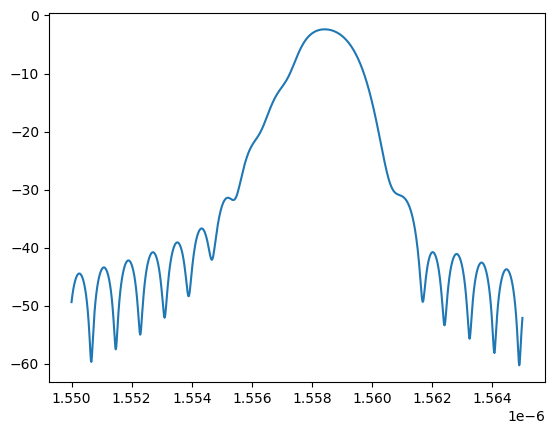

In [ ]:
plt.plot(fbg.wl,ref)